In [74]:
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [75]:
import hopsworks
import pandas as pd

In [76]:
project = hopsworks.login()
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/187540
Connected. Call `.close()` to terminate connection gracefully.


# Read in Data

In [77]:
wine_df = pd.read_csv("winequality.csv")
target = "quality"
wine_df

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [78]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [79]:
wine_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [80]:
# Replace spaces in column names
wine_df.columns = wine_df.columns.str.replace(' ', '_')


### Investigate Number of Missing Values per Column

In [81]:
wine_df.isna().sum()

type                     0
fixed_acidity           10
volatile_acidity         8
citric_acid              3
residual_sugar           2
chlorides                2
free_sulfur_dioxide      0
total_sulfur_dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [82]:
# Fill missing data with either random data or a category corresponding to "Unknown"
for column in wine_df.columns:
    if wine_df[column].isna().any() and pd.api.types.is_numeric_dtype(wine_df[column]):
        wine_df.loc[wine_df[column].isna(), column] = [i for i in np.random.choice(range(round(wine_df[column].min()), round(wine_df[column]. max())), wine_df[column].isna().sum())]
    elif wine_df[column].isna().any() and (pd.api.types.is_object_dtype(wine_df[column]) or pd.api.types.is_categorical_dtype(wine_df[column])):
        wine_df[column].fillna("Unknown")


In [83]:
wine_df.isna().sum()

type                    0
fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [84]:
# Check for duplicates and drop duplicates
duplicates = wine_df.duplicated().sum()
print(f"Number of duplicates: {duplicates}")
wine_df[wine_df.duplicated()]

Number of duplicates: 1168


,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
4,white,7.2,0.230,0.32,8.50,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
5,white,8.1,0.280,0.40,6.90,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
7,white,7.0,0.270,0.36,20.70,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
8,white,6.3,0.300,0.34,1.60,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
39,white,7.3,0.240,0.39,17.95,0.057,45.0,149.0,0.99990,3.21,0.36,8.6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6461,red,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
6462,red,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
6465,red,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
6479,red,6.2,0.560,0.09,1.70,0.053,24.0,32.0,0.99402,3.54,0.60,11.3,5


In [85]:
wine_df.drop_duplicates(inplace=True)
wine_df.reset_index(drop=True, inplace=True)
wine_df.shape

(5329, 13)

In [86]:
wine_df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,5329.000000,5329.000000,5329.000000,5329.000000,5329.000000,5329.000000,5329.000000,5329.000000,5329.000000,5329.000000,5329.000000,5329.000000
mean,7.222171,0.344357,0.318746,5.063014,0.056647,30.060143,114.189341,0.994536,3.224055,0.533243,10.548539,5.796022
std,1.332292,0.169322,0.147500,4.547110,0.036854,17.815588,56.781422,0.002966,0.160405,0.150296,1.186134,0.879922
min,3.800000,0.000000,0.000000,0.600000,0.000000,1.000000,6.000000,0.987110,2.720000,0.000000,8.000000,3.000000
25%,6.400000,0.230000,0.240000,1.800000,0.038000,16.000000,75.000000,0.992200,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.300000,0.310000,2.700000,0.047000,28.000000,116.000000,0.994640,3.210000,0.510000,10.400000,6.000000
75%,7.700000,0.410000,0.400000,7.500000,0.066000,41.000000,154.000000,0.996770,3.330000,0.600000,11.400000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


### Transform categorical variables into numerical variables

In [87]:
for column in wine_df.columns:
    if pd.api.types.is_categorical_dtype(wine_df[column]) or pd.api.types.is_object_dtype(wine_df[column]):
        one_hot = pd.get_dummies(wine_df[column], prefix=column)
        wine_df = wine_df.drop(column, axis = 1)
        wine_df = wine_df.join(one_hot)

display(wine_df)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,type_red,type_white
0,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,0,1
1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6,0,1
2,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6,0,1
3,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,0,1
4,6.2,0.320,0.16,7.0,0.045,30.0,136.0,0.99490,3.18,0.47,9.6,6,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5324,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6,1,0
5325,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,1,0
5326,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.00,11.2,6,1,0
5327,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,1,0


In [88]:
wine_df["type_red"].value_counts()

0    3970
1    1359
Name: type_red, dtype: int64

### Investigate predictive power of columns

In [89]:
# see https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b

<Axes: xlabel='x', ylabel='ppscore'>

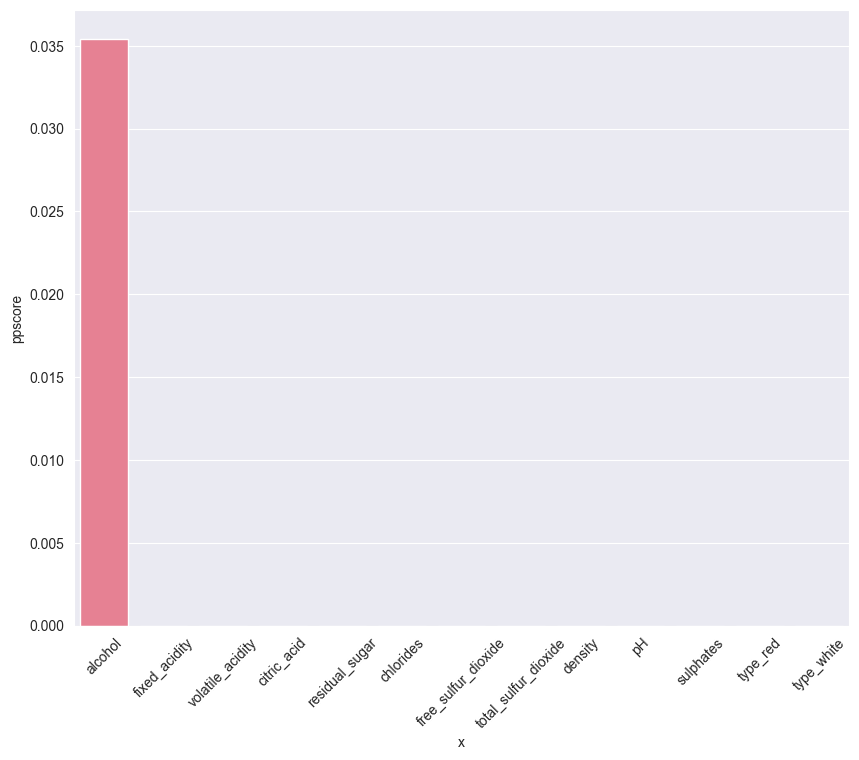

In [90]:
# Method 1: using ppscore
import ppscore as pps


predictors_df = pps.predictors(wine_df, y=target)
fig, ax = plt.subplots(figsize=(10,8))
ax.tick_params(axis='x', labelrotation=45)
sns.barplot(data=predictors_df, x="x", y="ppscore")

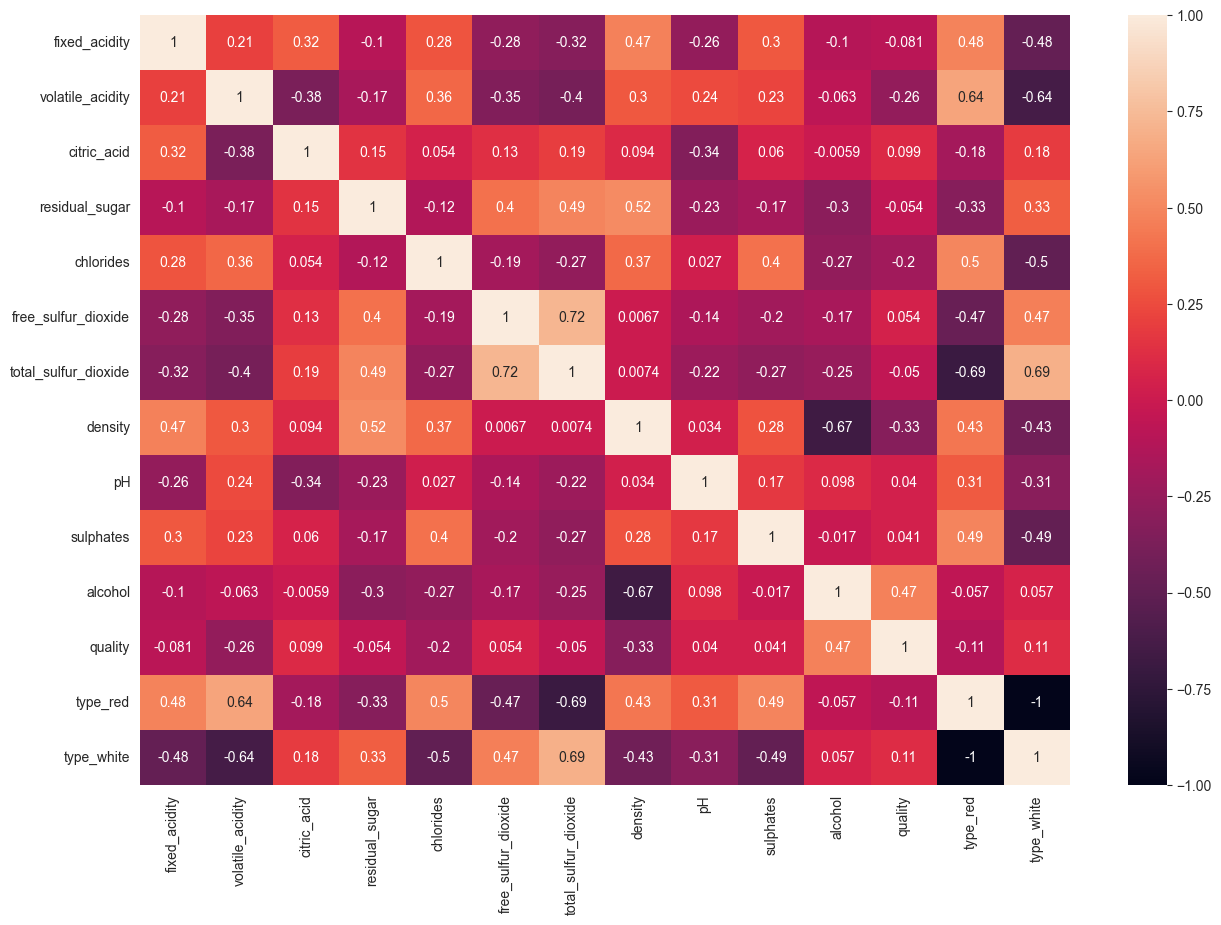

In [91]:
# Method 2: Exploring Correlation
plt.figure(figsize=(15,10))
cor = wine_df.corr()
sns.heatmap(cor, annot=True)
plt.show()

In [92]:
# Correlation with target variable quality
cor_quality = abs(cor["quality"])

threshold = 0.075

# Selecting only features with correlation coefficient > threshold
important_features = cor_quality[cor_quality>threshold].sort_values()
display(important_features)
print(f"Number of most important featuers: {len(important_features)-1}")

fixed_acidity       0.081171
citric_acid         0.098953
type_white          0.114889
type_red            0.114889
chlorides           0.201706
volatile_acidity    0.263238
density             0.326978
alcohol             0.469555
quality             1.000000
Name: quality, dtype: float64

Number of most important featuers: 8


In [93]:
# Checking for correlation between the important features
# If features are highly intercorrelated, we should only keep one and drop the other
# we should probably drop either red or white and maybe density since it is highly correlated with alcohol

feature_cor = wine_df[list(important_features.iloc[:-1].index)].corr().abs()

# Select upper triangle of correlation matrix
feature_cor_upper = feature_cor.where(np.triu(np.ones(feature_cor.shape), k=1).astype(bool))
display(feature_cor_upper)

,fixed_acidity,citric_acid,type_white,type_red,chlorides,volatile_acidity,density,alcohol
fixed_acidity,NaN,0.320299,0.479419,0.479419,0.283720,0.210297,0.472618,0.102421
citric_acid,NaN,NaN,0.184124,0.184124,0.054008,0.380242,0.093921,0.005889
type_white,NaN,NaN,NaN,1.000000,0.499757,0.640592,0.428757,0.057334
type_red,NaN,NaN,NaN,NaN,0.499757,0.640592,0.428757,0.057334
chlorides,NaN,NaN,NaN,NaN,NaN,0.363922,0.371341,0.269107
volatile_acidity,NaN,NaN,NaN,NaN,NaN,NaN,0.304391,0.063476
density,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.668216
alcohol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
# Find features with correlation greater than 0.95
features_to_exclude = [column for column in feature_cor_upper.columns if any(feature_cor_upper[column] > 0.95)]
print(f"Features to be excluded: {features_to_exclude}")

Features to be excluded: ['type_red']


In [95]:
# Find features to be kept
features_to_be_kept = [feature for feature in important_features.index.to_list() if feature not in features_to_exclude]
features_to_be_kept


['fixed_acidity',
 'citric_acid',
 'type_white',
 'chlorides',
 'volatile_acidity',
 'density',
 'alcohol',
 'quality']

In [96]:
# Drop features: drop all features that show a low correlation with the target variable and that are highly intercorrelated
for column in wine_df.columns:
    if column not in features_to_be_kept:
        wine_df.drop(column, axis=1, inplace=True)

display(wine_df)


,fixed_acidity,volatile_acidity,citric_acid,chlorides,density,alcohol,quality,type_white
0,7.0,0.270,0.36,0.045,1.00100,8.8,6,1
1,6.3,0.300,0.34,0.049,0.99400,9.5,6,1
2,8.1,0.280,0.40,0.050,0.99510,10.1,6,1
3,7.2,0.230,0.32,0.058,0.99560,9.9,6,1
4,6.2,0.320,0.16,0.045,0.99490,9.6,6,1
...,...,...,...,...,...,...,...,...
5324,6.8,0.620,0.08,0.068,0.99651,9.5,6,0
5325,6.2,0.600,0.08,0.090,0.99490,10.5,5,0
5326,5.9,0.550,0.10,0.062,0.99512,11.2,6,0
5327,5.9,0.645,0.12,0.075,0.99547,10.2,5,0


In [97]:
wine_df.shape

(5329, 8)

### Explore size of each group of the target variable

In [98]:
wine_df["quality"].value_counts()

6    2327
5    1755
7     857
4     206
8     149
3      30
9       5
Name: quality, dtype: int64

## Visualization and Exploration of Final Feature Selection

TODO

### Insert Wine Quality DataFrame into a FeatureGroup

In [101]:
wine_fg = fs.get_or_create_feature_group(
    name="wine",
    version=1,
    primary_key=['fixed_acidity','volatile_acidity', 'citric_acid', 'chlorides', 'density', 'alcohol', 'type_white'],
    description="Wine quality dataset")
wine_fg.insert(wine_df)


Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/187540/fs/187459/fg/209251


Uploading Dataframe: 0.00% |          | Rows 0/5329 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: wine_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/187540/jobs/named/wine_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x21c06043340>, None)

### Data Validation

In [ ]:
from great_expectations.core import ExpectationSuite, ExpectationConfiguration

def expect(suite, column, min_val, max_val):
    suite.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_be_between",
        kwargs={
            "column":column,
            "min_value":min_val,
            "max_value":max_val,
        }
    )
)

In [ ]:
#TODO

"""
suite = ExpectationSuite(expectation_suite_name="iris_dimensions")

expect(suite, "sepal_length", 4.5, 8.0)
expect(suite, "sepal_width", 2.1, 4.5)
expect(suite, "petal_length", 1.2, 7)
expect(suite, "petal_width", 0.2, 2.5)
iris_fg.save_expectation_suite(expectation_suite=suite, validation_ingestion_policy="STRICT")

"""